This notebook introduces the use of dictionaries for counting the frequency of some category of words in text, using sentiment (from the [AFINN sentiment lexicon](http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010)) in the time series data of tweets as an example.

This notebook uses data from the AFINN sentiment lexicon; for other dictionaries in wide use, see [MPQA](https://mpqa.cs.pitt.edu/lexicons/subj_lexicon/) (free for use with registration) and [LIWC](http://liwc.wpengine.com) (commercial).

Before running this notebook, install pandas:

```sh
source activate anlp
conda install pandas=0.24.0
conda install matplotlib=3.0.2
```

This first code cell imports the necessary Python libraries for the analysis.
* **`json`**: To read and parse the tweet data, which is stored in a JSON file.
* **`nltk`**: The Natural Language Toolkit, used here for its `casual_tokenize` function, which is effective at splitting tweet text into words (tokens).
* **`pandas`**: A powerful data analysis library used for creating and manipulating DataFrames and handling time series data.
* **`matplotlib`**: A plotting library used by pandas to generate visualizations.

In [1]:
# Import the json library to work with JSON files.
import json
# Import the Natural Language Toolkit (nltk) for text processing.
import nltk
# Import the pandas library for data manipulation and analysis, aliased as pd.
import pandas as pd
# Import the matplotlib library for plotting.
import matplotlib

The following cell defines a function `read_tweets_from_json` to process the raw tweet data. This function opens a specified JSON file, iterates through each tweet, extracts the creation date and the text, and then tokenizes the text. It returns a list where each item is a tuple containing the tweet's date and its list of tokens.

In [2]:
# read in json file of tweets and return a list of (date, tokenized text)

# Define a function that takes a filename as input.
def read_tweets_from_json(filename):
    
    # Initialize an empty list to store the processed tweets.
    tweets=[]
    # Open the specified file with UTF-8 encoding.
    with open(filename, encoding="utf-8") as file:
        # Load the entire JSON content from the file into a Python object.
        data=json.load(file)
        # Iterate through each tweet object in the loaded data.
        for tweet in data:
            # Extract the 'created_at' field from the tweet.
            created_at=tweet["created_at"]
            # Convert the date string into a pandas datetime object for time series analysis.
            date = pd.to_datetime(created_at)
            # Extract the 'text' field from the tweet.
            text=tweet["text"]
            # Use NLTK's casual tokenizer to split the tweet text into a list of words (tokens).
            tokens=nltk.casual_tokenize(text)
            # Append a tuple containing the date and the list of tokens to our main list.
            tweets.append((date, tokens))
    # Return the final list of processed tweets.
    return tweets

This cell defines the `dictionary_document_count` function. Its purpose is to count the "document frequency" of terms from a given dictionary. It iterates through each tweet and checks if any word in that tweet (converted to lowercase) exists in the provided dictionary. If a match is found, the tweet is marked with a `1` (present), otherwise `0` (absent). The results are returned as a pandas DataFrame, which is ideal for plotting and time series analysis.

In [3]:
# read in list of (date, tokens) tweets and count whether each tweet contains 
# a (lowercased) term in the argument dictionary.  Return as pandas dataframe
# for easier slicing/plotting)

# Define a function that takes tweet data and a dictionary of words as input.
def dictionary_document_count(data, dictionary):
    # Initialize an empty list to store the counts.
    counted=[]
    # Iterate through each tweet, unpacking the date and tokens.
    for date, tokens in data:
        # Initialize a value of 0 for the current tweet, indicating the word is not found yet.
        val=0
        # Iterate through each word (token) in the current tweet.
        for word in tokens:
            # Check if the lowercase version of the word is in the dictionary.
            if word.lower() in dictionary:
                # If a word is found, set the value to 1 and stop checking this tweet.
                val=1
        # Append a tuple containing the date and the binary frequency value (0 or 1) to the list.
        counted.append((date, val))
    # Create a pandas DataFrame from the list of counts.
    df=pd.DataFrame(counted, columns=['date','document frequency'])
    # Return the resulting DataFrame.
    return df

Here, we call the `read_tweets_from_json` function with the path to the `trump_tweets.json` file and store the returned list of processed tweets in the `tweets` variable.

In [4]:
# Call the function to read tweets and store the result in the 'tweets' variable.
tweets=read_tweets_from_json("../data/trump_tweets.json")

Here we'll define our own "immigration" dictionary by selecting words that we hypothesize are often found in the topic of immigration.

A `set` is created to hold words related to the topic of "immigration." Using a set provides a very fast way to check for the existence of an item, which is more efficient than searching through a list, especially for larger dictionaries.

In [5]:
# Create a set of words related to immigration for efficient lookups.
immigration_dictionary=set(["wall", "border", "borders", "immigrants","immigration"])

This cell calls the `dictionary_document_count` function, passing it the `tweets` data and the `immigration_dictionary`. The function returns a DataFrame showing a `1` for each tweet that contains at least one word from the dictionary and a `0` otherwise. The result is stored in the `counts` variable.

In [6]:
# Calculate the document frequency of the immigration words in the tweets.
counts=dictionary_document_count(tweets, immigration_dictionary)

The `plot_time` function is defined to visualize the frequency of dictionary terms over time. It first filters the data to include only tweets from 2015 onwards. Then, it **resamples** the daily data into monthly averages. `resample('M')` groups the data by month, and `.mean()` calculates the average document frequency for each month, effectively showing the proportion of tweets in that month that contained a dictionary term. Finally, it plots this time series.

In [7]:
# Define a function to plot the time series data.
def plot_time(counts):
    
    # Filter the DataFrame to only include tweets with a date after January 1, 2015.
    counts=counts[(counts['date'] > '2015-01-01')]
    
    # Resample the data by month ('M') based on the 'date' column and calculate the mean for each month.
    # This gives the proportion of tweets per month containing a dictionary word.
    means=counts.resample('M', on='date').mean() 
    
    # Plot the resulting time series data.
    means.plot()

This line calls the `plot_time` function to generate and display the time series plot for the immigration-related terms.

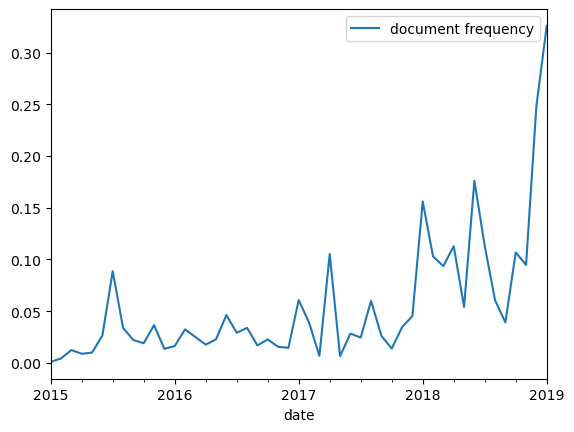

In [8]:
# You might need to run this command twice if you get a warning

# Call the plotting function with the calculated counts for the immigration dictionary.
plot_time(counts)

The output is a line graph that visualizes the proportion of Donald Trump's tweets containing words from the `immigration_dictionary` over time, aggregated monthly from 2015 onwards. The y-axis represents the "document frequency" (the proportion of tweets with the term), and the x-axis represents the date. This allows us to see trends and spikes in how often this topic was mentioned.

Q1: The AFINN dictionary is a sentiment lexicon, where words are rated on a five-point affect scale (-5 = most negative, 5 = most positive). Write a function `read_AFINN_dictionary` to read in this file and create two dictionaries like that above -- one for positive terms and one for negative terms. How did you decide the cutoff point for positive and negative?

This cell defines the `read_AFINN_dictionary` function. It reads the AFINN lexicon file, which contains words and their corresponding sentiment scores (from -5 to +5). The function categorizes each word as either positive or negative.

A cutoff of `>= 2` was chosen for positive words and `<= -2` for negative words. This decision excludes words with mild sentiment scores (-1, 0, 1), which could be considered neutral or weakly sentimental, aiming to create dictionaries of more clearly positive and negative terms. The function returns two sets, one for each category.

In [9]:
# Define a function to read the AFINN sentiment lexicon from a file.
def read_AFINN_dictionary(filename):
    # Initialize an empty list for positive words.
    positive=[]
    # Initialize an empty list for negative words.
    negative=[]
    # Open the specified lexicon file.
    with open(filename) as file:
        # Iterate through each line in the file.
        for line in file:
            # Remove trailing whitespace and split the line by the tab character into columns.
            cols=line.rstrip().split("\t")
            # The first column is the word.
            word=cols[0]
            # The second column is the sentiment value, converted to an integer.
            value=int(cols[1])
            # If the value is -2 or less, classify the word as negative.
            if value <= -2:
                negative.append(word)
            # If the value is 2 or more, classify the word as positive.
            elif value >= 2:
                positive.append(word)
    
    # Return the lists of positive and negative words, converted to sets for efficiency.
    return set(positive), set(negative)

This line calls the `read_AFINN_dictionary` function to process the `AFINN-111.txt` file. It unpacks the returned tuple of sets into two separate variables: `positive` and `negative`.

In [10]:
# Read the AFINN dictionary and store the results in 'positive' and 'negative' sets.
positive, negative=read_AFINN_dictionary("../data/AFINN-111.txt")

Q2: Create a plot (like that above) using the negative sentiment dictionary you created

These two lines first calculate the document frequency for the words in the `negative` sentiment dictionary and then call the `plot_time` function to visualize this data as a time series plot.

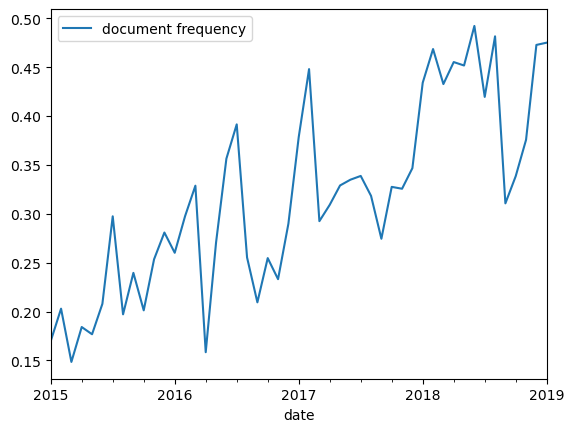

In [11]:
# Calculate the document frequency for the negative sentiment words.
counts=dictionary_document_count(tweets, negative)
# Plot the time series of negative word usage.
plot_time(counts)

This plot shows the proportion of tweets containing words from the `negative` sentiment dictionary over time. Similar to the first plot, it reveals trends in the usage of negative language in the tweets on a monthly basis.

Q3: Create a new dictionary of your own for a concept you'd like to measure in `trump_tweets.json` or `aoc_tweets.json`. The dictionary must contain at least 10 terms; you're free to create one for any category (except sentiment!), so be creative--we'll be comparing these in class on Thursday. Create a plot using that dictionary and data below.

Q4 (check-plus): for each of the terms in your dictionary, write a function `print_examples(tweets, dictionary)` to find one tweet that contains that term and print it out for your inspection. Is that term used in the same sense you expected?

The `print_examples` function is defined here to help inspect how words from a dictionary are used in context. For each `term` in the dictionary, it searches through the `data` (tweets) to find the first tweet containing that term. Once found, it prints the term alongside the full text of the tweet and then moves on to the next term in the dictionary. This is useful for verifying that the words are being used in the way the analyst intended.

In [12]:
# Define a function to print example tweets for each word in a dictionary.
def print_examples(data, dictionary):
    # Iterate through each term in the provided dictionary.
    for term in dictionary:
        # Set a flag to false; this will be used to stop after finding one example.
        flag=False
        # Iterate through each tweet in the data.
        for (date, tokens) in data:
            # Iterate through each word in the tweet's tokens.
            for word in tokens:
                # Check if the lowercase word matches the lowercase term.
                if word.lower() == term.lower():
                    # If a match is found, print the term and the joined tokens of the tweet.
                    print ("%s\t%s" % (term,' '.join(tokens)))
                    # Set the flag to true since we found an example.
                    flag=True
                    # Break the inner loop (over words) as we only need one example per tweet.
                    break
            # If the flag is true (an example was found and printed)...
            if flag:
                # Break the outer loop (over tweets) to move to the next dictionary term.
                break

This cell calls the `print_examples` function with the `tweets` data and the `immigration_dictionary` created earlier. This will print one sample tweet for each of the five words in that dictionary.

In [13]:
# Call the function to print example tweets for the immigration dictionary.
print_examples(tweets, immigration_dictionary)

immigration	RT @charliekirk11 : This is why we need a wall Illegal immigration is a serious threat to our country 90 % of all heroin comes across the b …
borders	It is becoming more and more obvious that the Radical Democrats are a Party of open borders and crime . They want nothing to do with the major Humanitarian Crisis on our Southern Border . #2020 !
immigrants	RT @Lrihendry : @realDonaldTrump They are eaten alive by hate for our President & his voters ! They care more about illegal immigrants than …
border	Mexico is doing NOTHING to stop the Caravan which is now fully formed and heading to the United States . We stopped the last two - many are still in Mexico but can ’ t get through our Wall , but it takes a lot of Border Agents if there is no Wall . Not easy !
wall	Mexico is doing NOTHING to stop the Caravan which is now fully formed and heading to the United States . We stopped the last two - many are still in Mexico but can ’ t get through our Wall , but it takes a lot of Bord

The output shows one example tweet for each word in the `immigration_dictionary`. This helps to confirm that the words are being used in the expected context related to border security and immigration policy.